In [2]:
import sys

import numpy as np

sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


  0%|          | 0/19 [00:00<?, ?it/s]

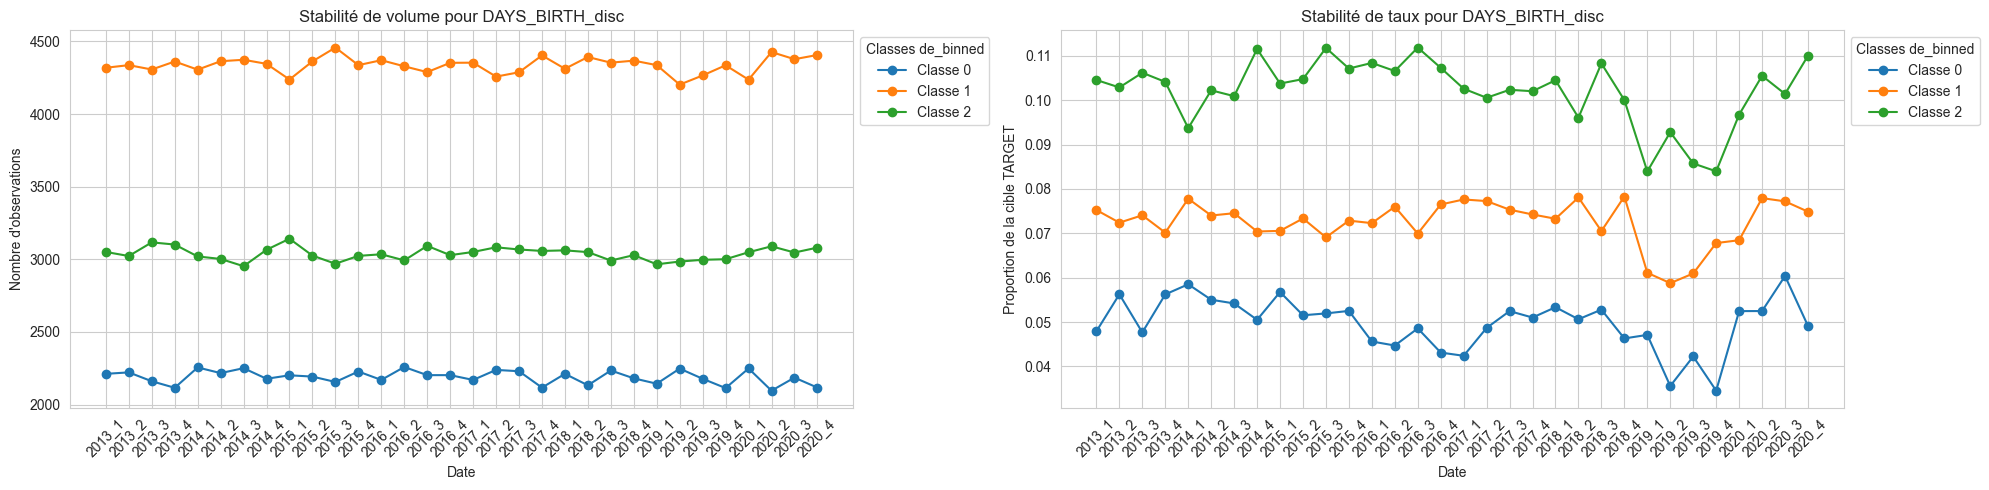

  5%|▌         | 1/19 [00:17<05:19, 17.75s/it]

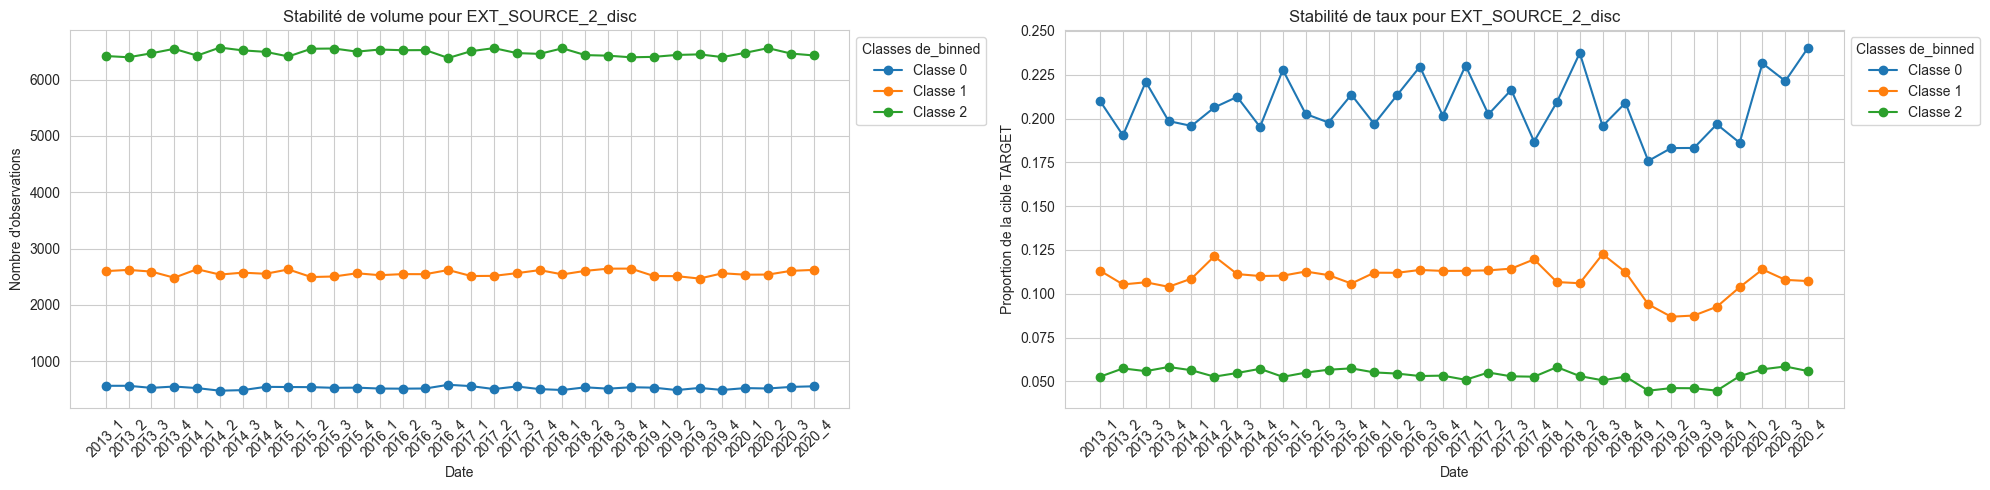

 11%|█         | 2/19 [00:37<05:19, 18.79s/it]

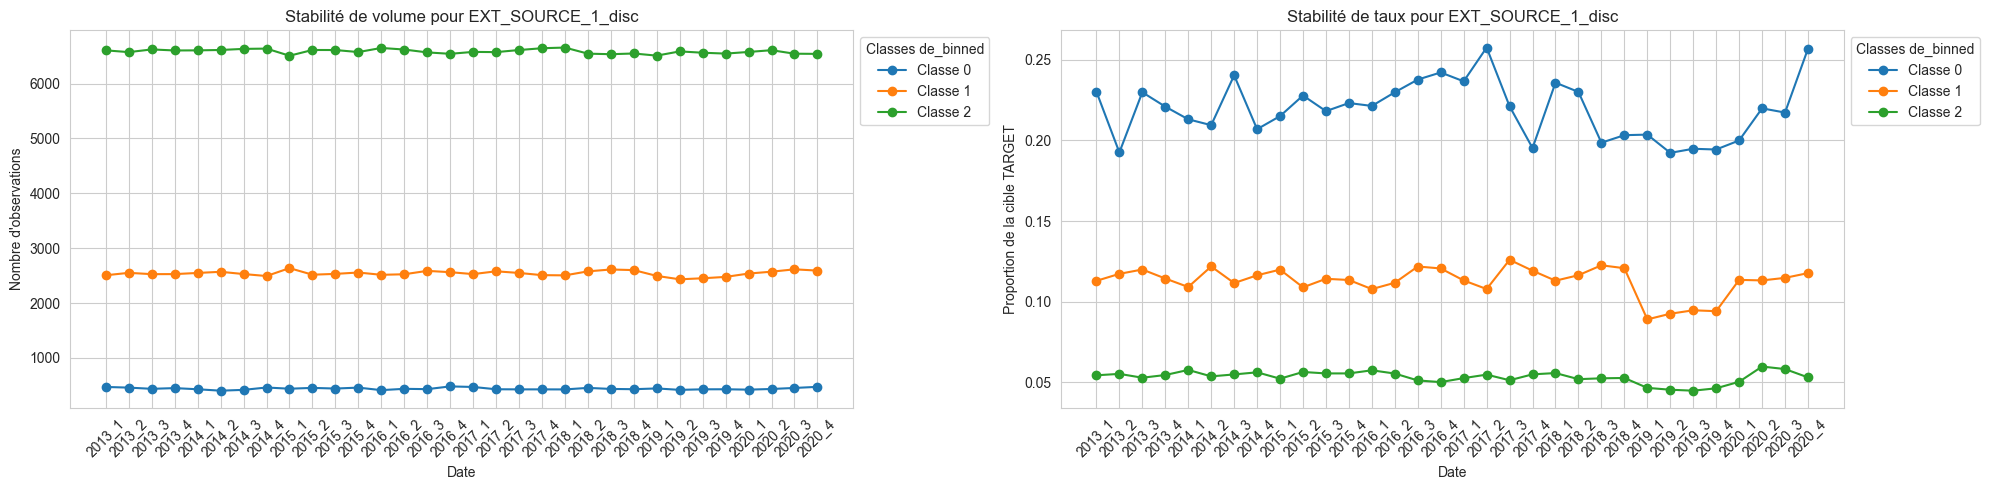

 16%|█▌        | 3/19 [00:56<05:06, 19.16s/it]

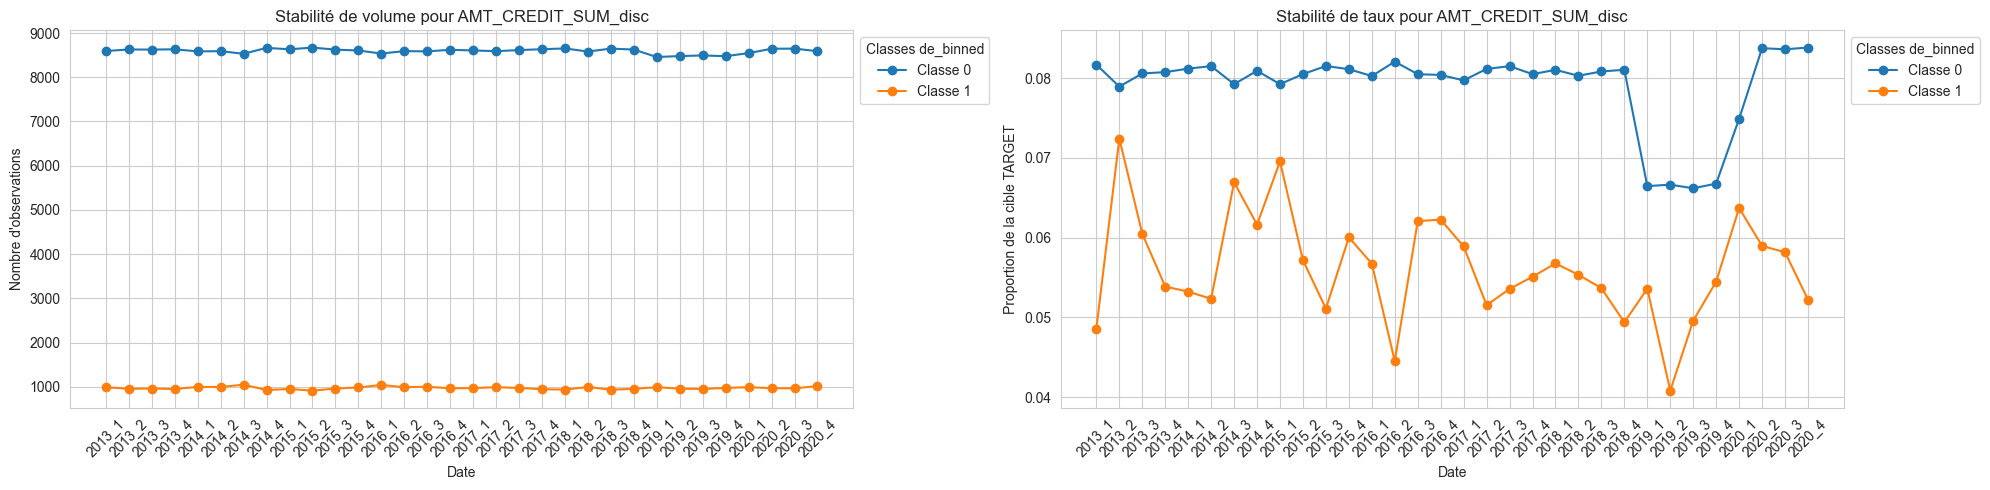

 21%|██        | 4/19 [01:16<04:53, 19.54s/it]

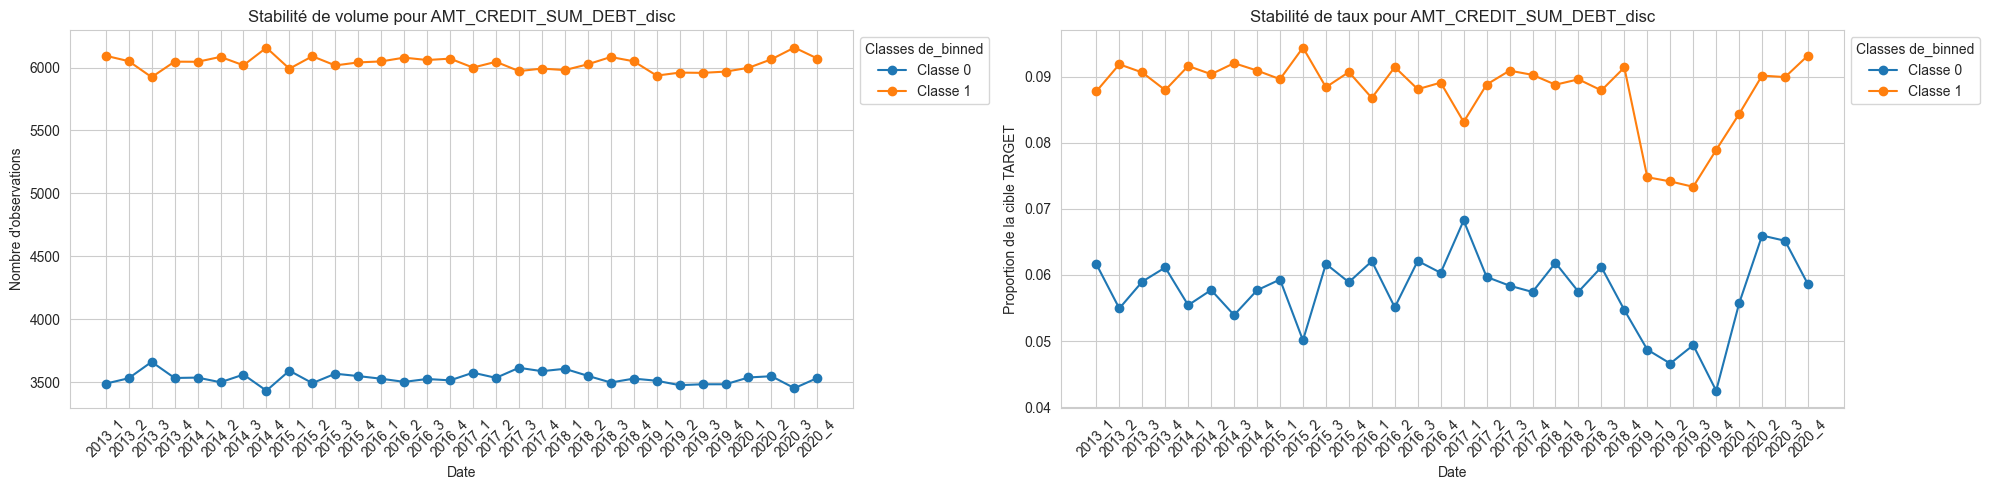

 26%|██▋       | 5/19 [01:35<04:30, 19.32s/it]

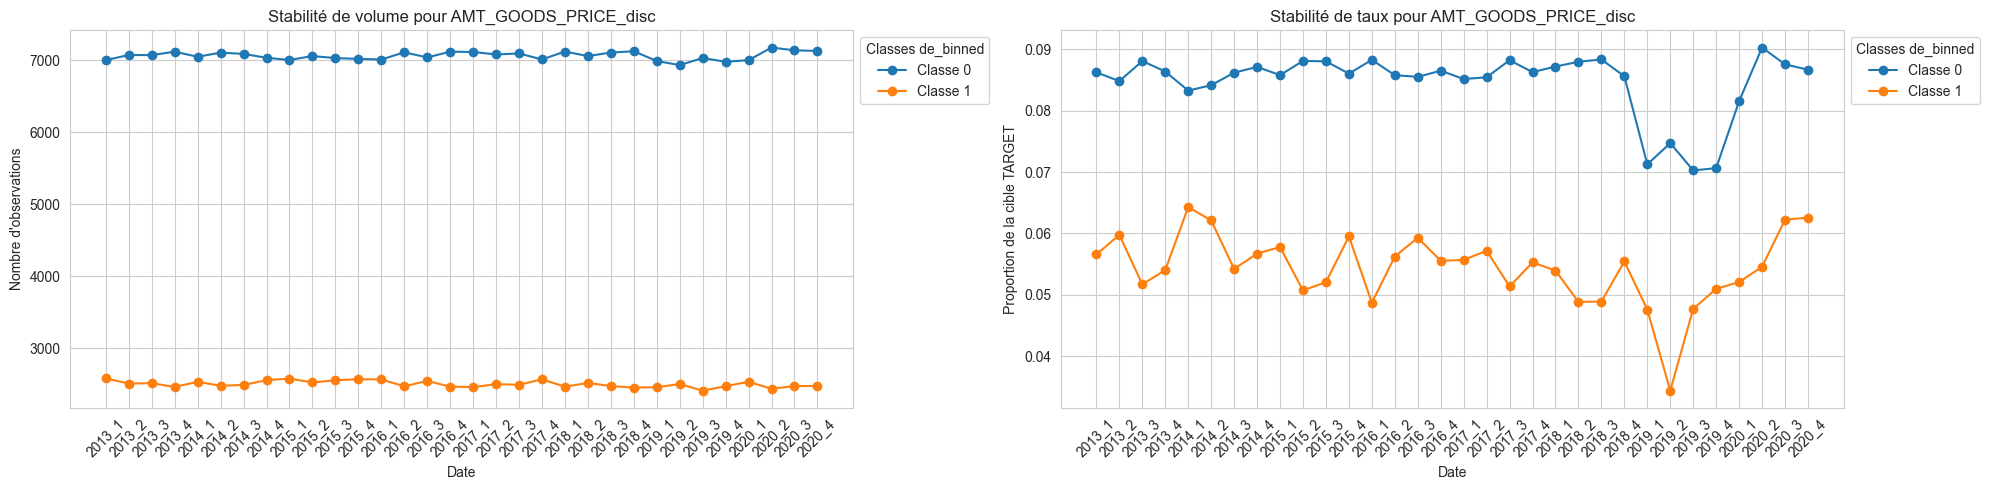

 32%|███▏      | 6/19 [01:53<04:01, 18.61s/it]

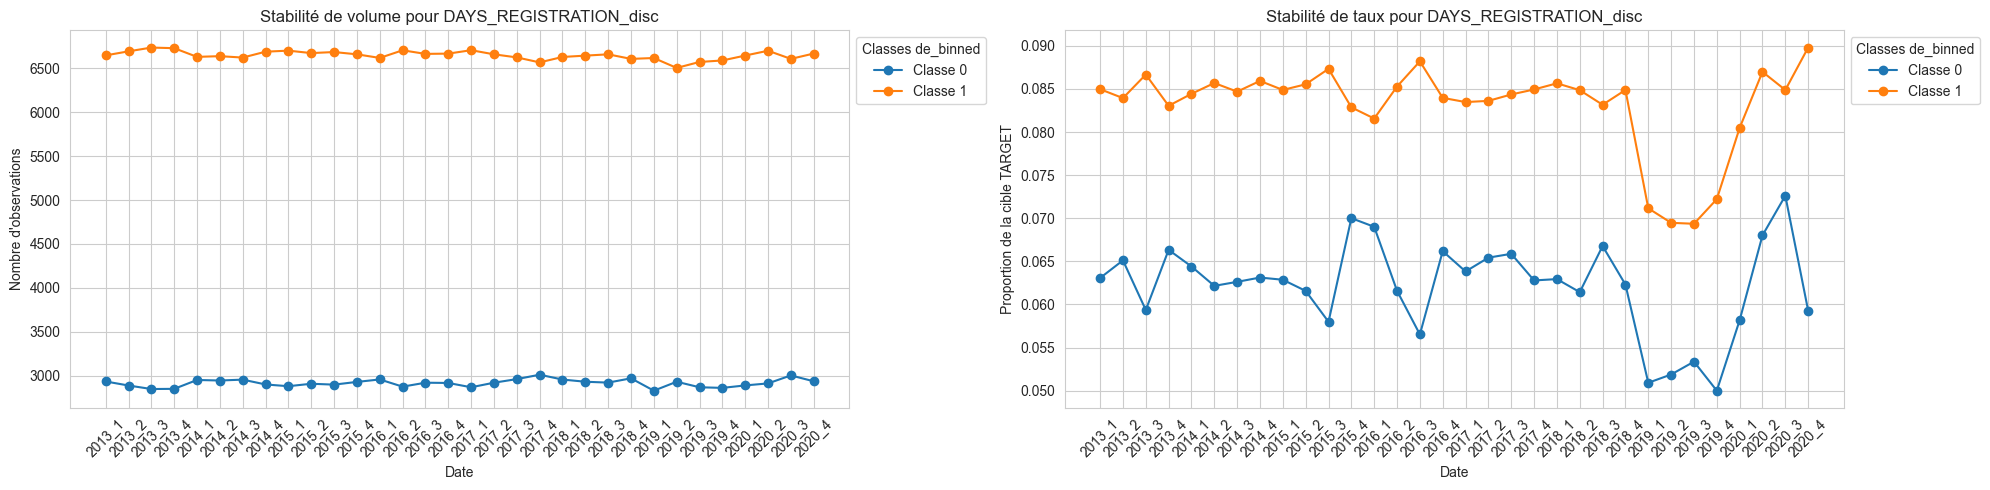

 37%|███▋      | 7/19 [02:11<03:43, 18.60s/it]

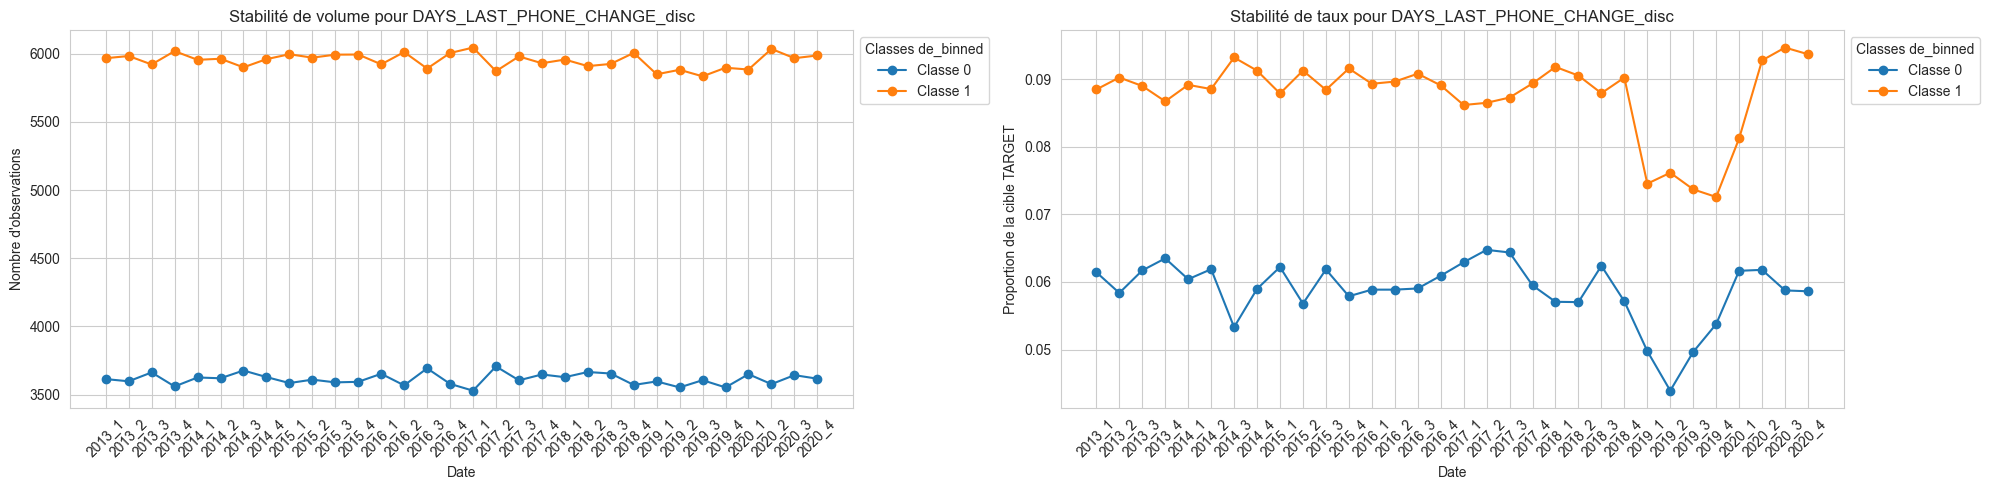

 42%|████▏     | 8/19 [02:28<03:19, 18.14s/it]

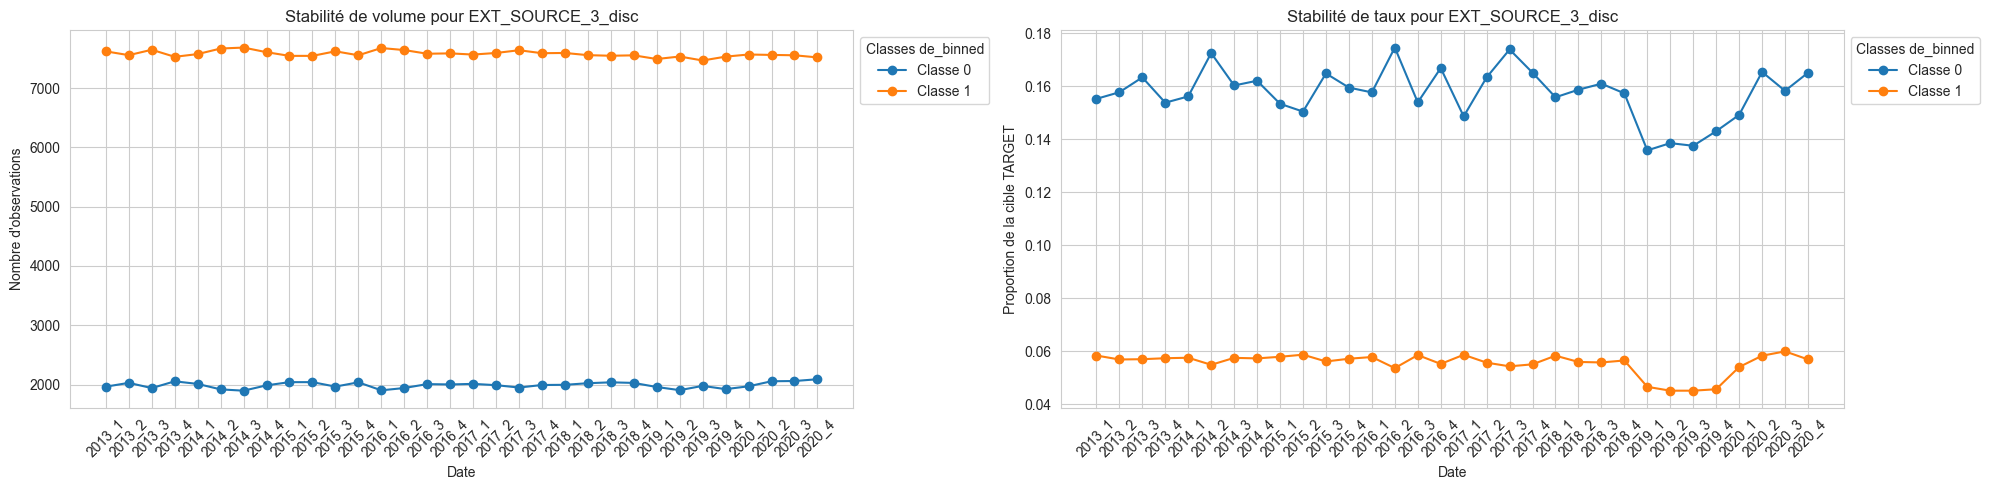

 47%|████▋     | 9/19 [02:46<02:58, 17.86s/it]

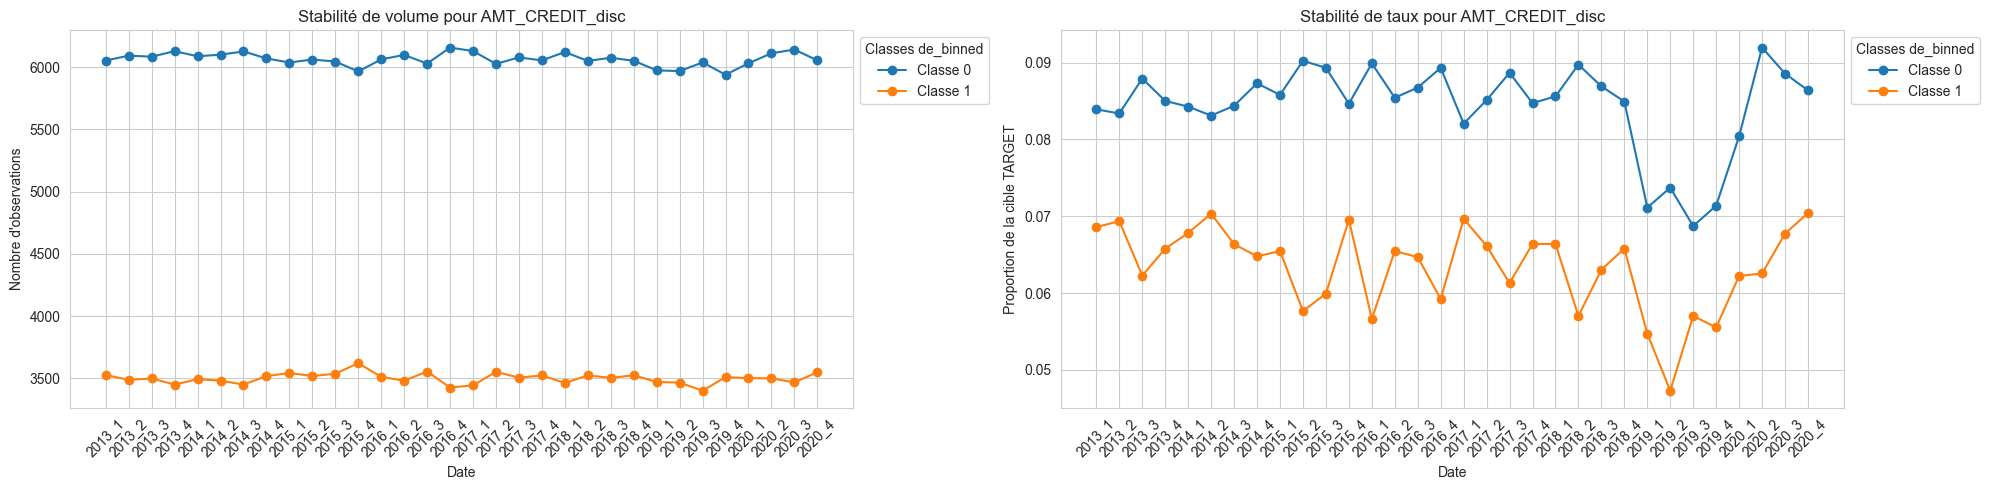

 53%|█████▎    | 10/19 [03:02<02:37, 17.47s/it]

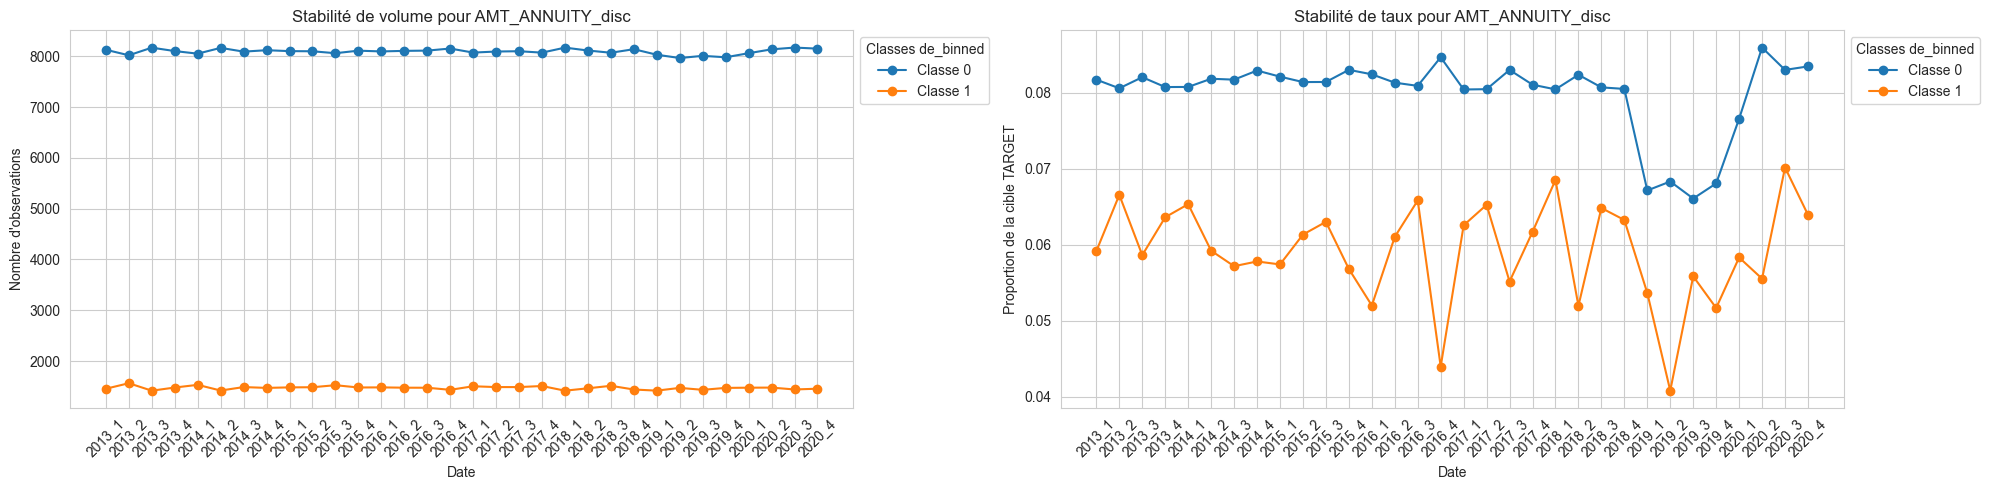

 58%|█████▊    | 11/19 [03:19<02:18, 17.27s/it]

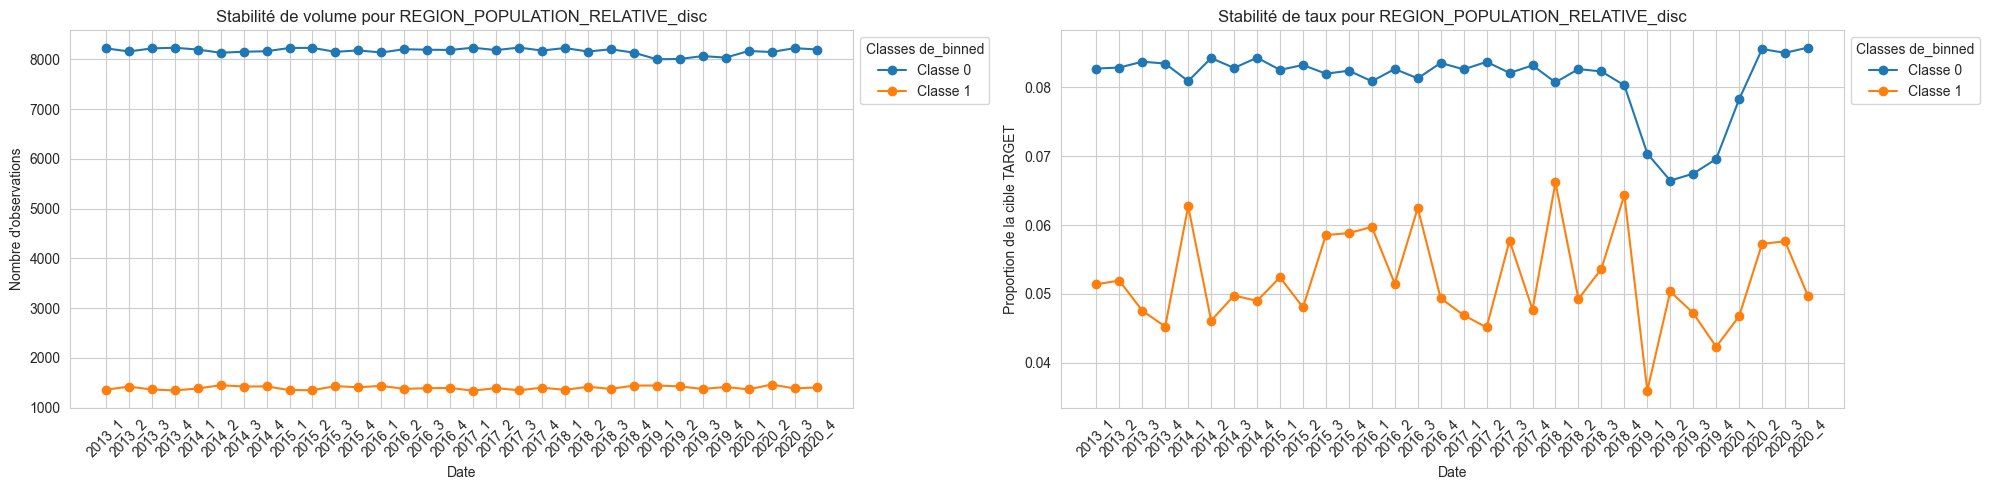

 63%|██████▎   | 12/19 [03:36<02:00, 17.17s/it]

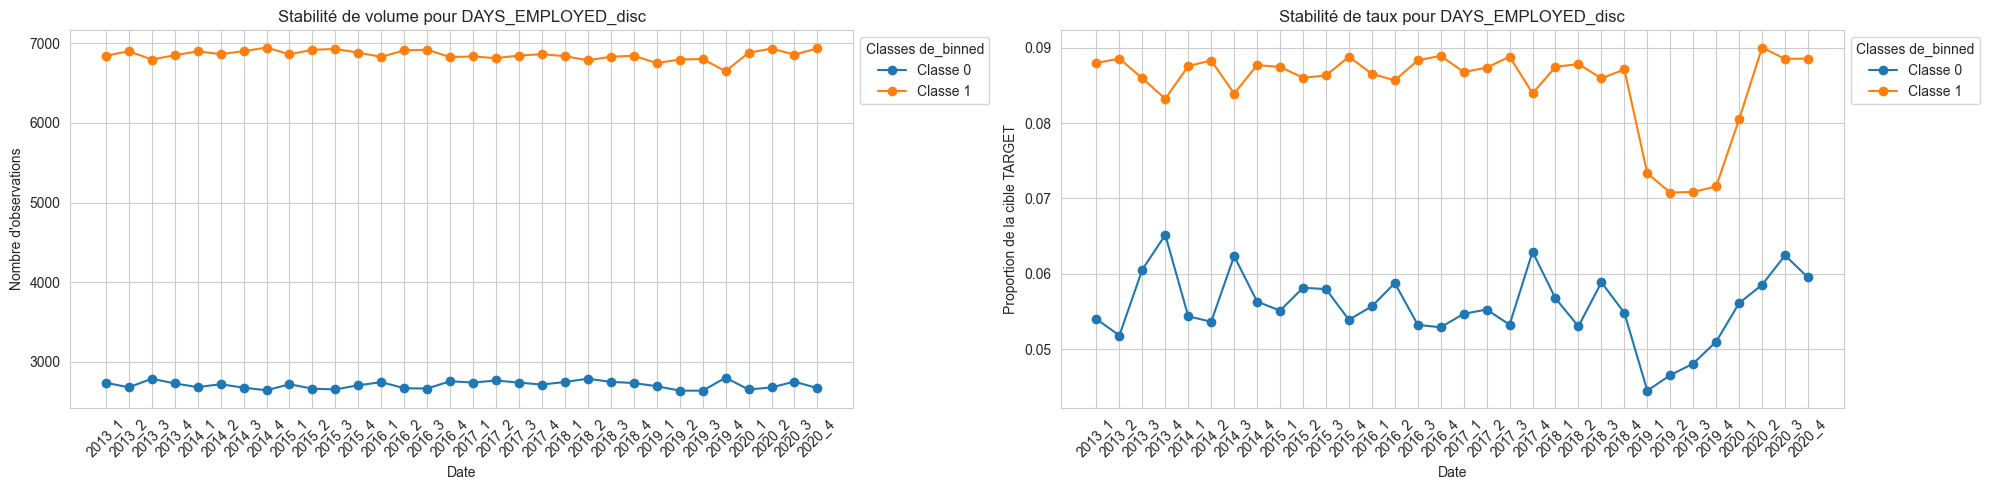

 68%|██████▊   | 13/19 [03:51<01:39, 16.66s/it]

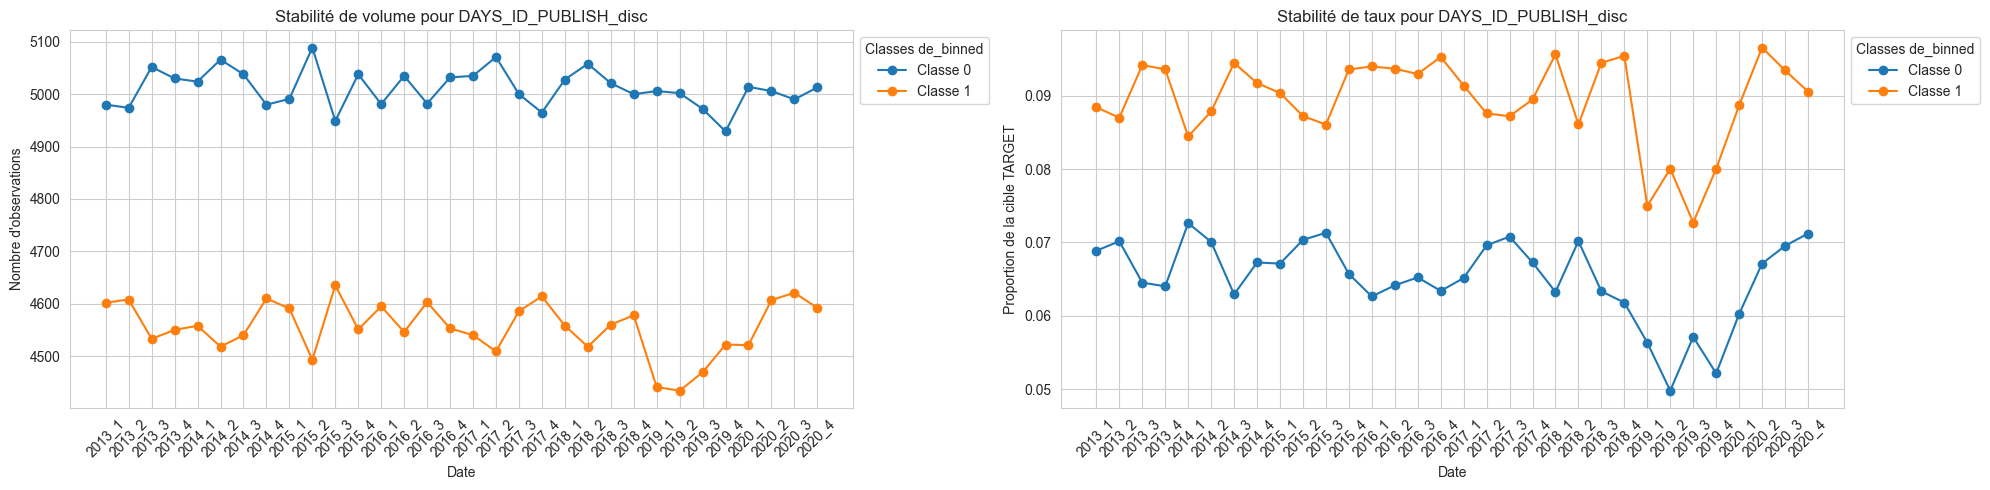

 74%|███████▎  | 14/19 [04:06<01:20, 16.15s/it]

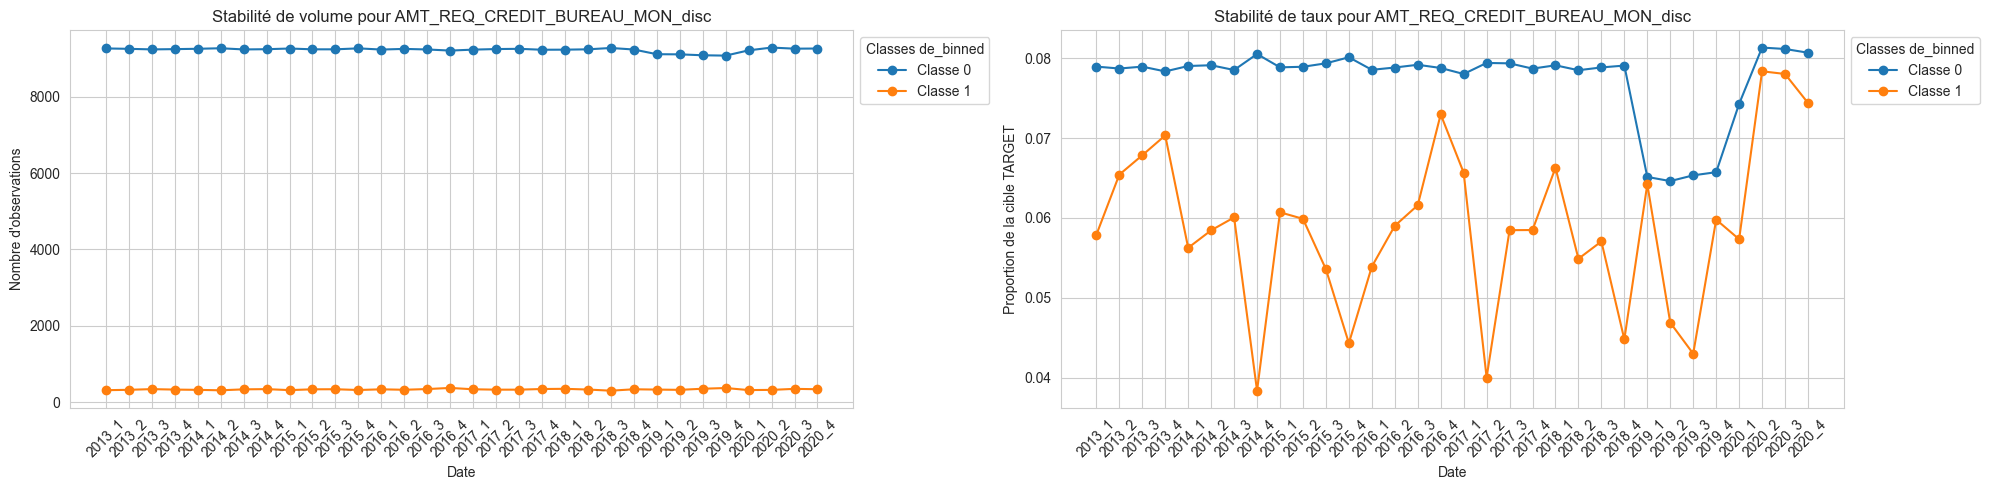

 79%|███████▉  | 15/19 [04:22<01:04, 16.01s/it]

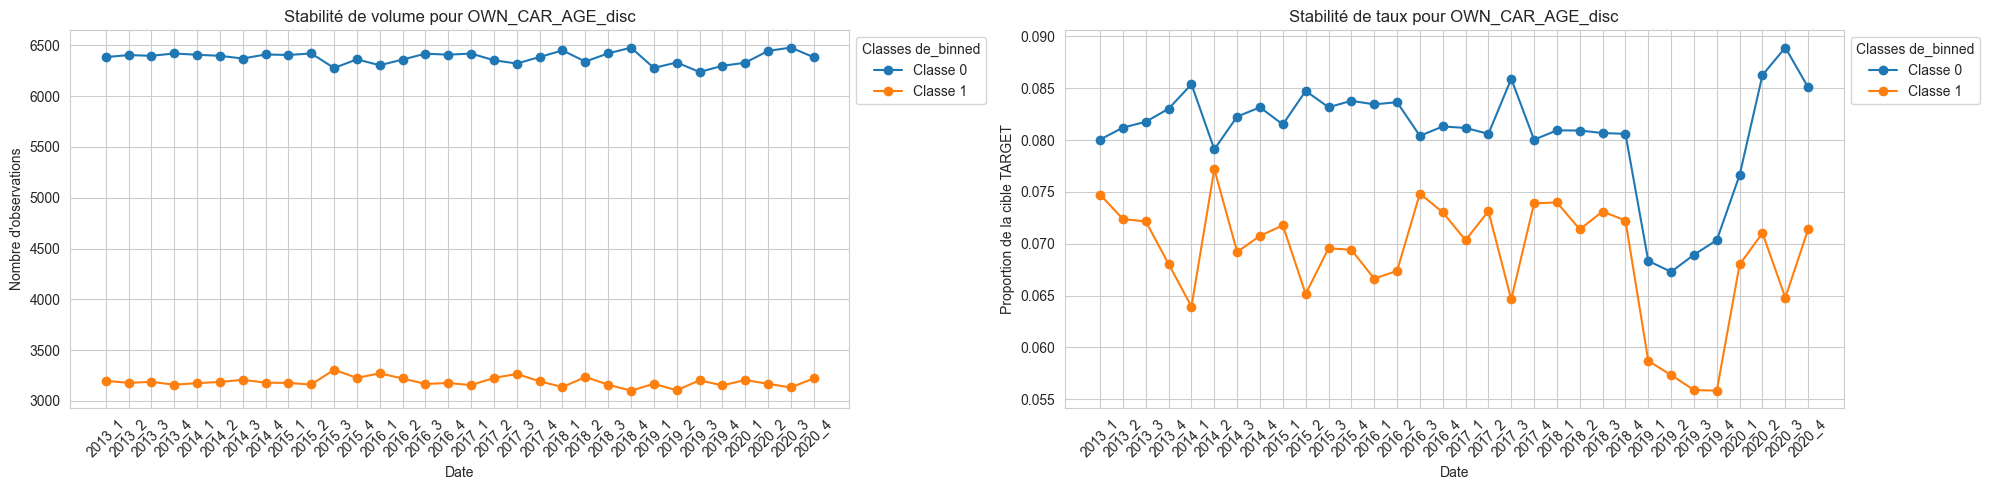

 84%|████████▍ | 16/19 [04:38<00:47, 16.00s/it]

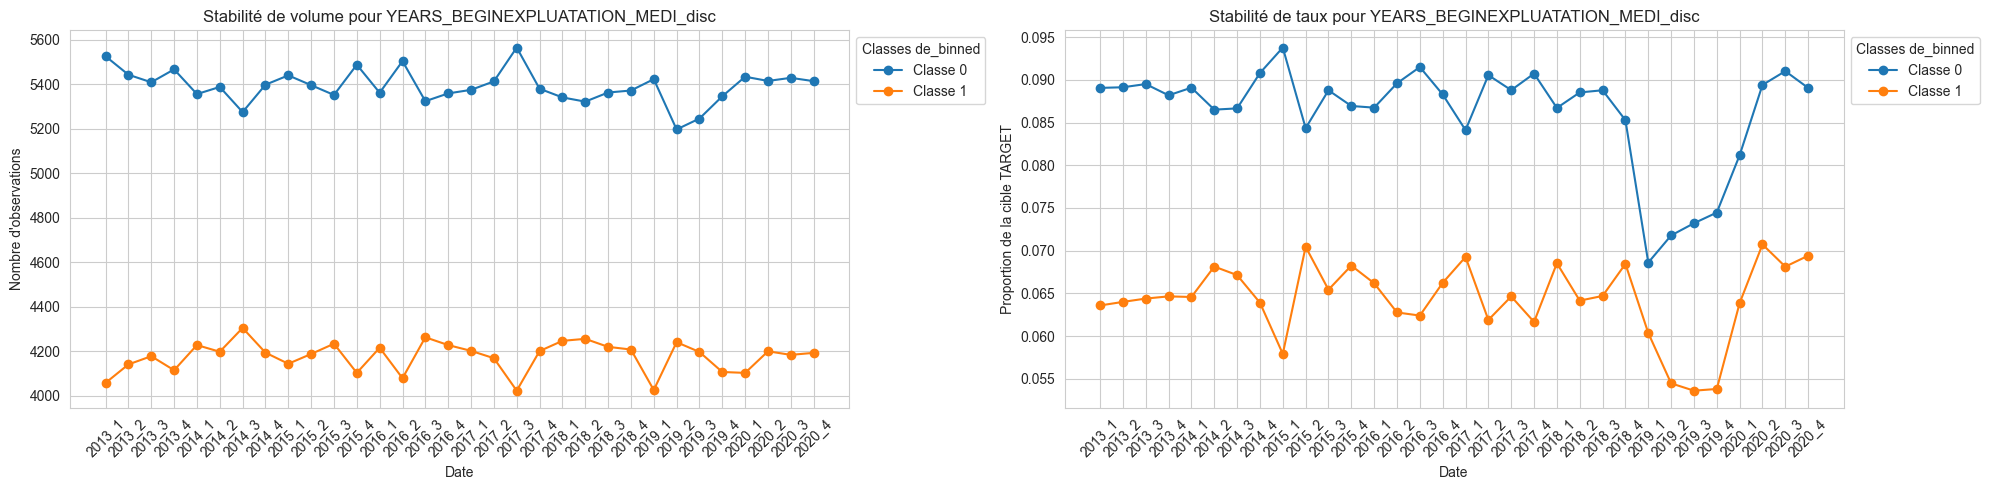

 89%|████████▉ | 17/19 [04:55<00:32, 16.19s/it]

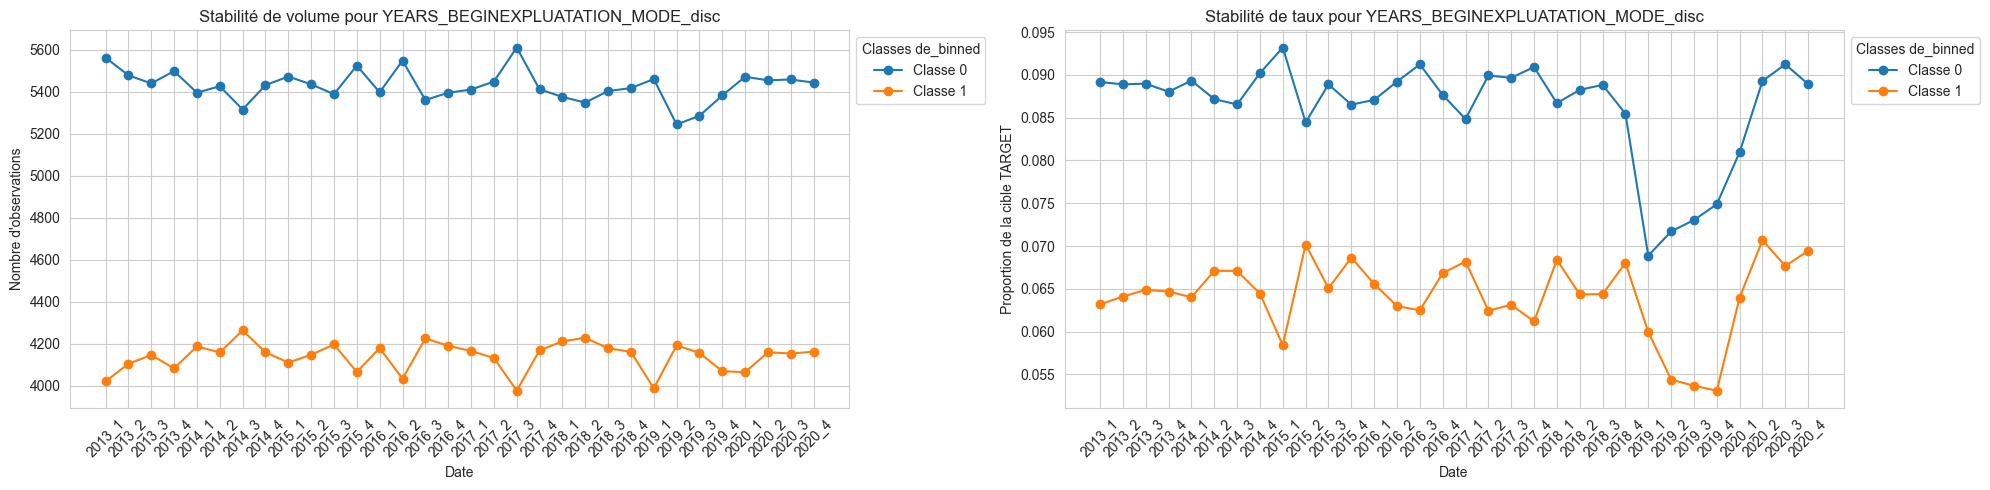

 95%|█████████▍| 18/19 [05:12<00:16, 16.61s/it]

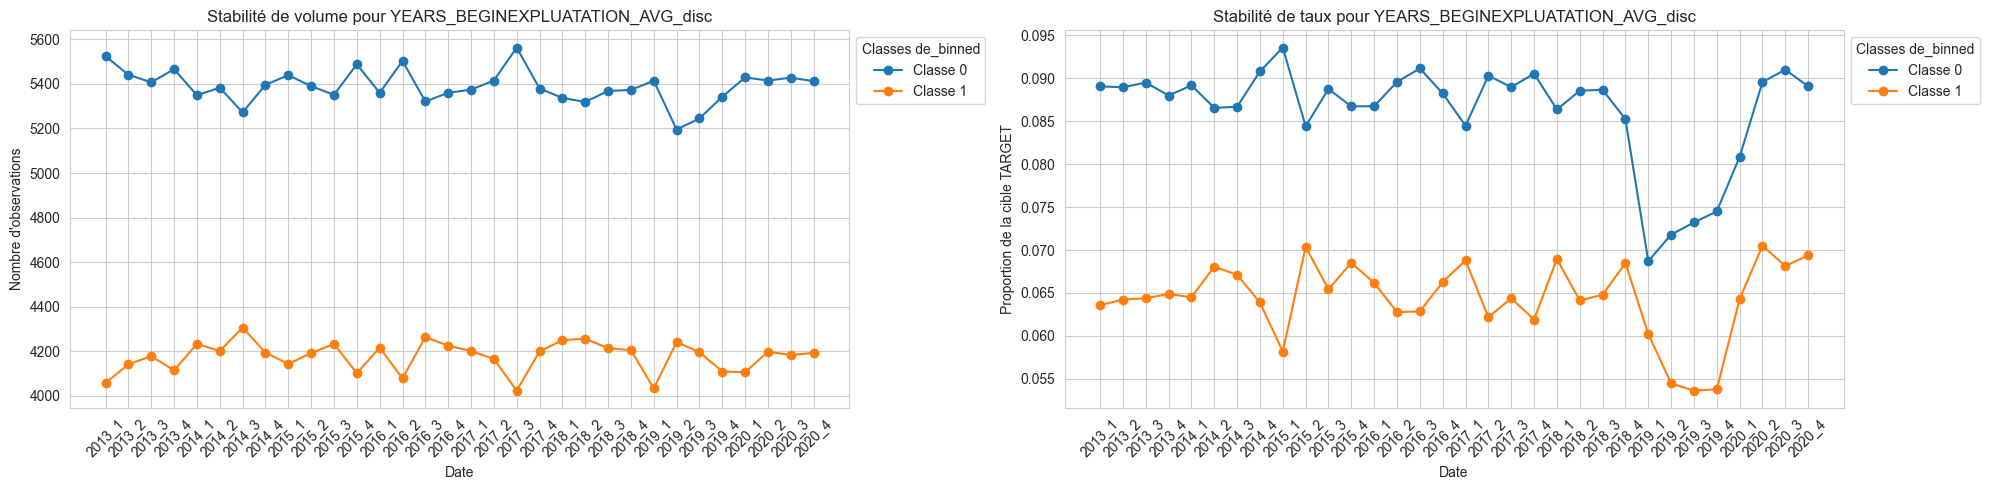

100%|██████████| 19/19 [05:29<00:00, 17.35s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [26]:
dataprep = DataPreparation(train, 0.3, plot = True)
train_prepared, test_prepared = dataprep.get_prepared_data()

In [25]:
train_prepared.to_csv("../data/train_prepared_70.csv")
test_prepared.to_csv("../data/test_prepared_70.csv")
#train_prepared = pd.read_csv("../data/train_preparedV2.csv", index_col=[0])
#test_prepared = pd.read_csv("../data/test_preparedv2.csv", index_col=[0])

# Modélisation

In [37]:
train_prepared.columns

Index(['date_mensuelle', 'TARGET', 'DAYS_BIRTH_disc_int',
       'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int',
       'AMT_CREDIT_SUM_disc_int', 'AMT_CREDIT_SUM_DEBT_disc_int',
       'AMT_GOODS_PRICE_disc_int', 'DAYS_REGISTRATION_disc_int',
       'DAYS_LAST_PHONE_CHANGE_disc_int', 'EXT_SOURCE_3_disc_int',
       'AMT_CREDIT_disc_int', 'AMT_ANNUITY_disc_int',
       'REGION_POPULATION_RELATIVE_disc_int', 'DAYS_EMPLOYED_disc_int',
       'DAYS_ID_PUBLISH_disc_int', 'AMT_REQ_CREDIT_BUREAU_MON_disc_int',
       'OWN_CAR_AGE_disc_int', 'YEARS_BEGINEXPLUATATION_MEDI_disc_int',
       'YEARS_BEGINEXPLUATATION_MODE_disc_int',
       'YEARS_BEGINEXPLUATATION_AVG_disc_int', 'NAME_INCOME_TYPE_discret',
       'NAME_EDUCATION_TYPE_discret', 'NAME_FAMILY_STATUS_discret',
       'OCCUPATION_TYPE_discret', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'LIVE_CITY_N

In [27]:
features = ['AMT_CREDIT_SUM_DEBT_disc_int', 'AMT_CREDIT_SUM_disc_int', 'DAYS_EMPLOYED_disc_int']

In [31]:
train_prepared[features]

,AMT_CREDIT_SUM_DEBT_disc_int,AMT_CREDIT_SUM_disc_int,DAYS_EMPLOYED_disc_int
0,[31111.5;43650000.0],[0.0;691899.68],[-2486;365243]
1,[-1083614.67;31111.2],[0.0;691899.68],[-17912;-2487]
2,[31111.5;43650000.0],[691914.75;198072344.25],[-2486;365243]
3,[-1083614.67;31111.2],[0.0;691899.68],[-2486;365243]
4,[-1083614.67;31111.2],[0.0;691899.68],[-2486;365243]
...,...,...,...
279995,[-1083614.67;31111.2],[0.0;691899.68],[-2486;365243]
279996,[31111.5;43650000.0],[0.0;691899.68],[-2486;365243]
279997,[31111.5;43650000.0],[0.0;691899.68],[-2486;365243]
279998,[31111.5;43650000.0],[0.0;691899.68],[-2486;365243]


In [32]:
reference_categories = {
    'AMT_CREDIT_SUM_DEBT_disc_int' : "[-1083614.67;31111.2]",
    'AMT_CREDIT_SUM_disc_int' : "[691914.75;198072344.25]", 
    #'EXT_SOURCE_2_disc_int' : "[0.46;0.85]",  
    #'EXT_SOURCE_1_disc_int' : "[0.41;0.96]", 
    #'EXT_SOURCE_3_disc_int' : "[0.35;0.9]", 
    'DAYS_EMPLOYED_disc_int' : "[-17912;-2487]"}

In [33]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [34]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.264459
         Iterations 7


# Prédiction

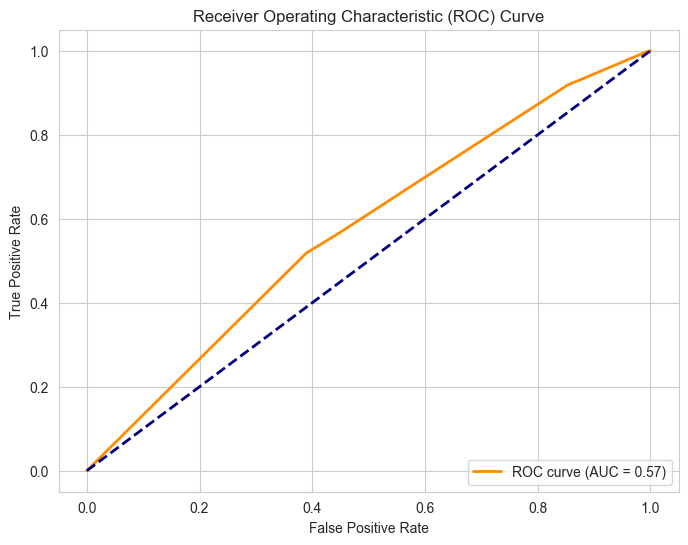

0.14900838533972616

In [35]:
pred = logit_model.predict(test_prepared)
fpr, tpr, thresholds = roc_curve(test_prepared["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

In [36]:
confusion_matrix(test_prepared["TARGET"], np.round(pred))

array([[23788,     0],
       [ 2319,     0]])

# Grille de score

In [19]:
GS = GridScore(train_prepared, logit_model)
grid_score = GS.compute_grid_score()

In [20]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-3.792699,0.0,0.000000,0.0,0.00,0.00
1,AMT_CREDIT_SUM_DEBT_disc_int,[-1083614.67;36746.34]_ref,0.000000,0.0,106.109325,11.0,2.24,39.11
2,AMT_CREDIT_SUM_DEBT_disc_int,[36747.0;43650000.0],0.330000,0.0,0.000000,11.0,5.32,60.89
3,AMT_CREDIT_SUM_disc_int,[619038.0;198072344.25]_ref,0.000000,0.0,80.385852,9.0,0.68,11.94
4,AMT_CREDIT_SUM_disc_int,[0.0;619036.2],0.250000,0.0,0.000000,9.0,6.88,88.06
5,EXT_SOURCE_2_disc_int,[0.46;0.85]_ref,0.000000,0.0,202.572347,19.0,3.55,67.42
6,EXT_SOURCE_2_disc_int,[0.0;0.16],0.630000,0.0,0.000000,19.0,1.20,6.04
7,EXT_SOURCE_2_disc_int,[0.16;0.46],0.340000,0.0,93.247588,19.0,2.81,26.54
8,EXT_SOURCE_1_disc_int,[0.41;0.96]_ref,0.000000,0.0,257.234727,24.0,3.52,67.78
9,EXT_SOURCE_1_disc_int,[0.0;0.16],0.800000,0.0,0.000000,24.0,1.32,6.73


## Calcul des scores individuels

In [21]:
df_score = GS.get_individual_score()

(array([ 5288.,  2844., 13104., 15912., 29356., 35590., 24933., 56844.,
        74579., 21550.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

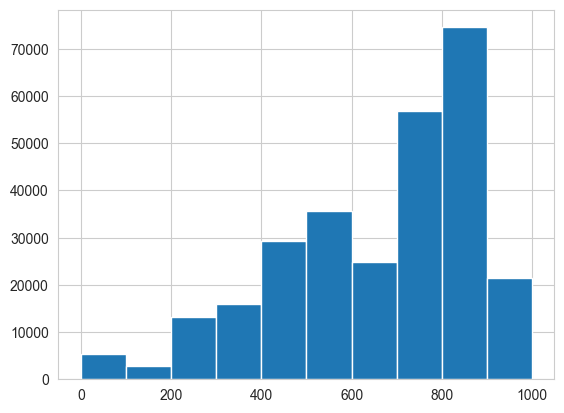

In [22]:
plt.hist(df_score["Score_ind"])

In [23]:
df_score.to_csv("../data/df_score.csv")